In [273]:
import numpy as np
import pandas as pd
import contextlib
import time
from functools import partial
from multiprocessing import Pool, cpu_count
import math
import matplotlib.pyplot as plt
import os
import errno
import pickle
import operator

In [7]:
# https://stackoverflow.com/questions/49555991/can-i-create-a-local-numpy-random-seed
@contextlib.contextmanager
def temp_seed(seed):
    state = np.random.get_state()
    np.random.seed(seed)
    try:
        yield
    finally:
        np.random.set_state(state)

In [212]:
class GMF():
    "Gaussian Matrix Factorization"
    def __init__(self, ratings_csv):
        self.ratings = pd.read_csv(ratings_csv) # read movielens ratings csv file into pandas dataframe
        self.center_and_scale_ratings()
        self.split_data()
    
    def center_and_scale_ratings(self):
        rmax, rmin = self.ratings['rating'].max(), self.ratings['rating'].min()
        rrange = rmax-rmin
        rmed = rmin + rrange/2.0
        self.ratings['rating'] = (self.ratings['rating'] - rmed)/rrange
        
        
    def filter_df(df,key,values):
        'Filter dataframe based on values of given key'
        return df[df[key].isin(values)]

    def split_data(self,train_percent=80, dev_percent=10, test_percent=10):
        "For every user, split movies into train(80%), dev(10%), and test(10%) sets"
        assert(train_percent+dev_percent+test_percent==100)
        train_stop = train_percent*0.01
        dev_stop = (train_percent + dev_percent)*0.01
        users = self.ratings['userId'].unique()
        train_ids = []
        dev_ids = []
        test_ids = []
        for user in users:
            df = GMF.filter_df(ratings, 'userId', [user])
            with temp_seed(42):
                ids = list(df.index)
                np.random.shuffle(ids)
                size = len(ids)

            train_ids.extend(ids[:int(train_stop*size)])
            dev_ids.extend(ids[int(train_stop*size):int(dev_stop*size)])
            test_ids.extend(ids[int(dev_stop*size):])

        self.ratings.loc[train_ids,'data_label'] = 'train'
        self.ratings.loc[dev_ids,'data_label'] = 'dev'
        self.ratings.loc[test_ids,'data_label'] = 'test'
        self.train = GMF.filter_df(self.ratings,'data_label',['train'])
        self.dev = GMF.filter_df(self.ratings,'data_label',['dev'])
        self.test = GMF.filter_df(self.ratings,'data_label',['test'])


#     def ratings_part_update(prefs, atts, row):
# #         user, movie, rating = row['userId'], row['movieId'], row['rating']
#         user, movie, rating = row[0], row[1], row[2]
#         return (rating - np.dot(prefs[user],atts[movie]))**2

    def calc_log_likelihood(self, ratings, prefs, atts):
        'Return log likelihood of data given preferences and attributes'

        users = ratings['userId'].unique()
        movies = ratings['movieId'].unique()
        prefs_part = sum([sum(np.square(prefs[i])) for i in prefs.keys()]) * (- 0.5 * 1.0/self.pref_std)
        atts_part = sum([sum(np.square(atts[j])) for j in atts.keys()]) * (- 0.5 * 1.0/self.att_std)
        ratings_part = 0
#         f = partial(GMF.ratings_part_update, prefs, atts)
#         with Pool(cpu_count()) as p:
#             updates = p.map(f, map(list,ratings.itertuples(index=False)))
#             ratings_part += sum(list(updates))
        for row in ratings.itertuples(index=False):
            user, movie, rating = row[0], row[1], row[2]
            dotprod = (np.dot(prefs[user],atts[movie]))
            if math.isnan(dotprod): print((user,movie), prefs[user],atts[movie])
            ratings_part += np.square(rating - dotprod)
        ratings_part = - 0.5 * ratings_part
        return prefs_part + atts_part + ratings_part

    def pref_step(self, ratings, user):
        pref = self.prefs[user]
        step = 0
        for row in ratings.itertuples(index=False):
            movie, rating = row[1], row[2]
            att = self.atts[movie]
            step += (rating - (np.dot(pref, att)))*att

        step += (- 1.0 / self.pref_std) * pref
        return step

    def att_step(self, ratings, movie):
        att = self.atts[movie]
        step = 0
        for row in ratings.itertuples(index=False):
            user, rating = row[0], row[2]
            pref = self.prefs[user]
            step += (rating - (np.dot(pref, att)))*pref
        step += (- 1.0 / self.att_std) * att
        return step

    def update_pref(self,user):
            update = self.learning_rate * self.pref_step(GMF.filter_df(self.train,'userId',[user]),user)
            return (user,(self.prefs[user] + update))


    def update_att(self,movie):
            update = self.learning_rate * self.att_step(GMF.filter_df(self.train,'movieId',[movie]),movie)
            return (movie, (self.atts[movie] + update))

    def normalize(v):
        return (v / np.linalg.norm(v))

    def MAP(self, K,pref_std,att_std,learning_rate = 1, eps = 100, num_epochs=100):
        'Return MAP estimate of preferences and attributes vector by peforming coordinate ascent'
        self.K = K # Dimension of latent space, or number of "genres"
        self.pref_std = pref_std # standard deviation of user preferences vector
        self.att_std = att_std # standard deviation of movie attributes vector
        self.learning_rate = learning_rate
        users = self.train['userId'].unique()
        movies = self.train['movieId'].unique()
        # Initialize preferences and attribute vectors randomly
        self.prefs = dict()
        self.atts = dict()
        for user in users:
            self.prefs[user] = GMF.normalize(np.random.normal(0,self.att_std**2,(self.K)))
        for movie in movies:
            self.atts[movie] = GMF.normalize(np.random.normal(0,self.pref_std**2,(self.K)))
        t1 = time.time()
        # Calculate log likelihood
        log_likelihood = self.calc_log_likelihood(self.train,self.prefs,self.atts)
        t2 = time.time()
        print(f'log_likelihood = {log_likelihood}', f'\nlog likelihood calc time = {t2-t1} s')
        self.log_likelihoods = [log_likelihood]
        old_deltas_ma = 0
        self.deltas = []
        epochs = 0
        converged = False
        while not converged:
            t2 = time.time()
            # Parallel coordinate ascent for MAP estimation
            with Pool(cpu_count()) as p:
                new_prefs = p.imap(self.update_pref,users,500) # chunksize =500 (chosen almost arbitrarily)
                self.prefs = dict([*new_prefs])
                new_atts = p.imap(self.update_att,movies,500)
                self.atts = dict([*new_atts])
            t3 = time.time()
            print(f'time taken for one update = {t3-t2}s')
#             for user in users:
#                 self.prefs[user] += learning_rate * self.pref_step(GMF.filter_df(self.train,'userId',[user]),user)
#             for movie in movies:
#                 self.atts[movie] += learning_rate * self.att_step(GMF.filter_df(self.train,'movieId',[movie]),movie)
            new_log_likelihood = self.calc_log_likelihood(self.train,self.prefs,self.atts)
            self.log_likelihoods.append(new_log_likelihood)
            delta = new_log_likelihood - log_likelihood
            abs_delta = abs(delta)
            self.deltas.append(delta)
            print(f'new_log_likelihood = {new_log_likelihood}', f'\n delta = {delta}')
            log_likelihood = new_log_likelihood

            if abs_delta < eps or epochs >= num_epochs or delta<0:
                converged = True

            
#             mask = np.full(len(self.deltas),0)
#             if len(self.deltas)>2:
# #                 print(len(self.deltas))
#                 mask[-2:] = 1
#                 deltas_ma = np.ma.average(self.deltas,weights=mask)
#                 print(f'old_deltas_ma, deltas_ma = {old_deltas_ma},{deltas_ma}')
#                 if abs(old_deltas_ma - deltas_ma) < eps:
#                     converged = True
#                 old_deltas_ma = deltas_ma

            epochs += 1

        return self.prefs, self.atts

    @staticmethod
    def plot_log_likelihood(lls, deltas, eps=None):
        if eps is None:
            eps = 1
        f,ax = plt.subplots(2,1, figsize=(10,15))
        ax[0].plot(lls, 'o-')
        ax[1].plot((deltas), 'o-', label='log(delta)')
        ax[1].plot(np.arange(len(deltas)), np.full(len(deltas),eps), label='epsilon')
        ax[0].set_xlabel('epoch')
        ax[1].set_xlabel('epoch')
        ax[0].set_ylabel('log likelihood')
        ax[1].set_ylabel('delta := change in log likelihood')
        ax[1].legend()

    def RMSE(self,data_label, prefs=None,atts=None):
        if data_label == 'train':
            data = self.train
        elif data_label == 'dev':
            data = self.dev
        elif data_label == 'test':
            data = self.test
        else:
            print("data_label should be either 'train', 'dev', or 'test'")
            return
        if prefs is None:
            prefs = self.prefs
        if atts is None:
            atts = self.atts

        sq_errors = []
        for row in data.itertuples(index=False):
                user, movie, rating = row[0], row[1], row[2]
                try:
                    att = atts[movie]
                except:
#                     print(f'skipping movie {movie}')
                    continue
                predicted_rating = np.dot(prefs[user], att)
                sq_error = (rating - predicted_rating)**2
                sq_errors.append(sq_error)
        return np.sqrt(np.mean(sq_errors))
    
        
        
        

In [257]:
def hp_search(ratings_csv, search_file='hp_search/hp_dict', num_searches=1, K_domain=(50,1001),  pref_std_domain=(0.01,1), att_std_domain=(0.01,1),learning_rate_domain=(0.001,.1), eps=10,num_epochs=200,overwrite=False):
    'Select best hyper parameters from given domains (tuple of reals [low,high) denoting domain of uniform search)'
    if os.path.isfile(search_file):
        with open(search_file, 'rb') as file: 
            hp_dict = pickle.load(file)
    else:
        os.makedirs(os.path.dirname(search_file), exist_ok=True)
        hp_dict = {}
    
    gmf = GMF(ratings_csv)
    for i in range(num_searches):
        if os.path.isfile(search_file):
            with open(search_file, 'rb') as file: 
                hp_dict = pickle.load(file)
        
        if type(pref_std_domain)==float:
                pref_std = pref_std_domain
        else:
            pref_std = round(np.random.uniform(pref_std_domain[0], pref_std_domain[1]), 3)
    #             att_std = np.random.uniform(att_std_domain[0], att_std_domain[1])
            att_std = pref_std
        
        if type(K_domain)==int:
            K = K_domain
        else:
            K = int(np.random.uniform(K_domain[0], K_domain[1]))

        if type(learning_rate_domain)==float:
            learning_rate = learning_rate_domain
        else:
            learning_rate = round(np.random.uniform(learning_rate_domain[0], learning_rate_domain[1]),3)
        print(f'K = {K}, learning_rate={learning_rate}, pref_std = {pref_std}')
        prefs,atts = gmf.MAP(K,pref_std,att_std,learning_rate, eps, num_epochs)
        RMSE_train = round(gmf.RMSE('train'),3)
        RMSE_dev = round(gmf.RMSE('dev'),3)
        print(f'RMSE_train = {RMSE_train}\n RMSE_dev = {RMSE_dev}')

        key = f"K_{K}_prefattstd_{pref_std}_lr_{learning_rate}_eps_{eps}"
        if key in hp_dict and not overwrite:
            continue
        else:
            hp_dict[key] = {'prefs': prefs, 'atts': atts, 'K':K, 'lr':learning_rate, 'eps':eps, 'pref_std':pref_std,  
                            'att_std':att_std, 'log_likelihoods':gmf.log_likelihoods, 'deltas':gmf.deltas,
                            'RMSE_train': RMSE_train,
                            'RMSE_dev':RMSE_dev}
        with open(search_file, 'wb') as file:
            pickle.dump(hp_dict,file)

#     hp_dict = dict(sorted(hp_dict.items(),key=lambda item: item[1]['RMSE_dev'] ))
#     pickle.dump(hp_dict,search_file)

In [214]:
data_dir = 'hw2-datasets/movielens/'
ratings_csv = data_dir+'ratings.csv'
ratings = pd.read_csv(ratings_csv)
# tags = pd.read_csv(data_dir+'tags.csv')
movies_df =  pd.read_csv(data_dir+'movies.csv')
# links = pd.read_csv(data_dir+'links.csv')

In [274]:
print(ratings['userId'].unique().size)
print(ratings['movieId'].unique().size)
gmf.train.size,gmf.dev.size,gmf.test.size

610
9724


(402095, 50295, 51790)

In [141]:
# run single MAP estimate like this ...
gmf = GMF(ratings_csv)

In [ ]:
K,pref_std,att_std = 100,.1,.1
prefs, atts = gmf.MAP(K,pref_std,att_std,learning_rate=.01,eps=10)

In [ ]:
# search hyper parameter space like so ... 
hp_search(ratings_csv,K_domain=(1,1000),learning_rate_domain=(0.001,0.05),num_searches=3)

In [266]:
with open('hp_search/hp_dict', 'rb') as f:
    r = pickle.load(f)
    # sort dictionary based on dev RMSE
    hp_dict = dict(sorted(r.items(),key=lambda item: item[1]['RMSE_dev'] ))
    best = hp_dict[list(hp_dict.keys())[0]]

In [ ]:
print(best['RMSE_dev'],best['RMSE_train'],best['K'],best['lr'],best['pref_std'],best['eps'])
gmf.plot_log_likelihood(best['log_likelihoods'],best['deltas'],eps=best['eps'])

      movieId                         title  \
1939     2571            Matrix, The (1999)   
2996     4011                 Snatch (2000)   
3568     4886         Monsters, Inc. (2001)   
6534    54286  Bourne Ultimatum, The (2007)   
6772    60069                 WALL·E (2008)   

                                           genres  
1939                       Action|Sci-Fi|Thriller  
2996                        Comedy|Crime|Thriller  
3568  Adventure|Animation|Children|Comedy|Fantasy  
6534                        Action|Crime|Thriller  
6772  Adventure|Animation|Children|Romance|Sci-Fi  
      movieId                             title                       genres
257       296               Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller
277       318  Shawshank Redemption, The (1994)                  Crime|Drama
1211     1610  Hunt for Red October, The (1990)    Action|Adventure|Thriller
2078     2762           Sixth Sense, The (1999)         Drama|Horror|Mystery
3196     4308       

Text(0.5, 1.0, 'Latent Space of 2 Dimensions')

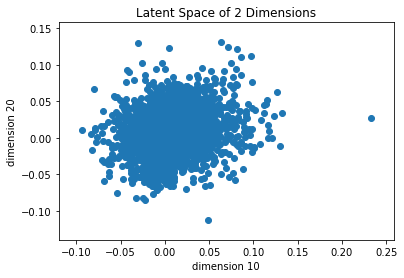

In [279]:
# inspect latent space
movies = gmf.train['movieId'].unique()
dim0,dim1 = 10,20 # plot these two dimensions against each other
xs = [best['atts'][movie][dim0] for movie in movies]
ys = [best['atts'][movie][dim1] for movie in movies]
mxs = list(zip(movies,xs))
mys = list(zip(movies,ys))
mxs.sort(key=operator.itemgetter(1))
mys.sort(key=operator.itemgetter(1))
top_mxs = mxs[-5:]
print(GMF.filter_df(movies_df, 'movieId',[mx[0] for mx in top_mxs]))
top_mys = mys[-5:]
print(GMF.filter_df(movies_df, 'movieId',[my[0] for my in top_mys]))

plt.scatter(xs, ys)
plt.xlabel(f'dimension {dim0}')
plt.ylabel(f'dimension {dim1}')
plt.title('Latent Space of 2 Dimensions')